In [18]:
from rpy2 import robjects
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime
import yaml
import os

# Convert pandas dataframe
from rpy2.robjects import pandas2ri
pandas2ri.activate()

output_dir = 'output_12-20-2gamma/'
#output_dir = 'output_12-10-gammaI/'

dept_avail = os.listdir(output_dir)


rainfall = pd.read_csv('haiti-data/fromAzman/rainfall.csv', index_col = 0, parse_dates = True)
cases    = pd.read_csv('haiti-data/fromAzman/cases_corrected.csv', index_col=0, parse_dates =True)


params_name = ['sigma', 'betaB', 'mu_B', 'XthetaA', 'thetaI', 'gammaI', 
              'lambda', 'lambdaR', 'r', 'rhoA', 'XrhoI', 'std_W', 
              'epsilon', 'k', 'foi_add', 'Rtot_0', 'gammaA', 
              'H', 'D', 'mu', 'alpha', 'I_0', 
              'A_0' , 'B_0', 'RI1_0', 'RI2_0', 'RI3_0', 'RA1_0', 
              'RA2_0', 'RA3_0']

params_name =["sigma","betaB","mu_B","XthetaA","thetaI","gammaI","lambda","lambdaR","r","rhoA","XrhoI","std_W","epsilon","k","foi_add",
              "gammaA","Rtot_0","H","D","mu","alpha","I_0","A_0","B_0","RI1_0","RI2_0","RI3_0","RA1_0","RA2_0","RA3_0","rhoI"]

compartments = ['S', 'I', 'A', 'RA1', 'RA2', 'RA3', 'RI1', 'RI2', 'RI3', 'W', 'B', 'cases']

stream = open('haiti-data/input_parameters.yaml', 'r')
input_parameters = yaml.load(stream)

dept_name = [list(pop.keys())[0] for pop in input_parameters['population']]

t_start = input_parameters['t_start']
t_for = datetime.date(2029,12,21)

# computes precipitation sample
def project_rain(rainfall, tf):
    nd = 14 #days sampled - must be multiple of 7 d
    
    dti = rainfall.iloc[0].name.date()
    dtf = rainfall.iloc[-1].name.date()
    
    rain_prj_index = pd.DatetimeIndex(start =  dtf + datetime.timedelta(1), 
                                      end = tf, freq = 'D')
    rain_prj = np.zeros((rain_prj_index.shape[0], 10))

    # Full years of data available
    years = range(dti.year+1, dtf.year-1)

    # each nd days, assign an al precipitation.
    for i, date in enumerate(pd.date_range(dtf + datetime.timedelta(1), tf, freq = str(nd)+'D')):
        dd = date.day
        if (date.month == 2 and dd == 29):
            dd = 28
        pick = datetime.date(np.random.choice(years), date.month, dd)
        #print(pick, i, rainfall.loc[pd.date_range(pick, pick + datetime.timedelta(nd-1))].values.shape, rain_prj[nd * i: nd * (i+1)].shape)
        rain_prj[nd * i: nd * (i+1)] = rainfall.loc[pd.date_range(pick, pick + datetime.timedelta(nd-1))].values

    rain_prj = pd.DataFrame(rain_prj, index = rain_prj_index, columns = dept_name)
    
    return rain_prj

rain_prj = project_rain(rainfall, t_for)
rain = pd.concat((rainfall, rain_prj))
rain.to_csv('haiti-data/proj/rainfall.csv', index_label = 'date')

### Extracting best performing parameters

In [19]:
index = pd.DatetimeIndex(start =  t_start,  end = t_for, freq = 'W-SAT')
r_source = robjects .r['source'];

all_data = {}
all_params = pd.DataFrame(np.zeros((len(dept_avail), len(params_name))),  columns = params_name, index = dept_avail)
for dp in dept_avail:
    dept_data = {}
    robjects.r('departement <- "' + dp + '"')
    robjects.r('output_dir <- "' + output_dir + '"')
    robjects.r('run_level <- 4')
    robjects.r('nsim <- 10')
    print(dp)
    r_source('~/phd/haiti-ocv-pomp/scripts/forecast_haitiOCV.R')
    all_params.loc[dp] = robjects.r['params']
    for comp in compartments:
        temp = pandas2ri.ri2py(robjects.r[comp])
        temp.index = index
        temp.drop('date',axis=1, inplace = True)
        dept_data[comp] = temp
    all_data[dp] = dept_data
    
all_params.drop(['I_0', 'A_0','B_0','RI1_0','RI2_0','RI3_0','RA1_0','RA2_0','RA3_0'], axis =1, inplace = True)
# Convert years in days, 'mu', 'alpha'
rates = [ "gammaI", "gammaA", "rhoA", 'rhoI']
params_disp = all_params.copy()
params_disp.loc[:,'rhoI'] = params_disp.loc[:,'XrhoI'] * params_disp.loc[:,'rhoA']
params_disp.loc[:,'thetaA'] = params_disp.loc[:,'XthetaA'] * params_disp.loc[:,'thetaI']
params_disp.drop(['mu', 'alpha', 'XrhoI', 'XthetaA', 'lambda'], axis =1, inplace = True)
#print(params_disp)
for p in rates:
    params_disp.loc[:,p] =  1/(params_disp.loc[:,p]/365.25)
    

#aa = params_disp.loc[:,'gammaA'].iloc[:,0]
#params_disp.drop('gammaA', axis = 1, inplace=True)
#params_disp.loc[:,'gammaA'] = aa

params_disp = params_disp.reindex(columns=sorted(params_disp.columns))

Nord-Est


/usr/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Nord
Artibonite
Nord-Ouest
Ouest
Grande_Anse
Sud
Centre
Sud-Est
Nippes


In [21]:
params_disp

,D,H,Rtot_0,betaB,epsilon,foi_add,gammaA,gammaI,k,lambdaR,mu_B,r,rhoA,rhoI,sigma,std_W,thetaA,thetaI
Nord-Est,353.0,1727524.0,0.005673,0.316733,0.803858,0.000337,1.777569,1.201125,435.472914,0.742508,97.951331,0.652516,383.403581,543.694255,0.243304,0.013238,0.0002,0.000581
Nord,353.0,1727524.0,0.005673,0.316733,0.803858,0.000337,1.777569,1.201125,435.472914,0.742508,97.951331,0.652516,383.403581,543.694255,0.243304,0.013238,0.0002,0.000581
Artibonite,353.0,1727524.0,0.005673,0.316733,0.803858,0.000337,1.777569,1.201125,435.472914,0.742508,97.951331,0.652516,383.403581,543.694255,0.243304,0.013238,0.0002,0.000581
Nord-Ouest,353.0,1727524.0,0.005673,0.316733,0.803858,0.000337,1.777569,1.201125,435.472914,0.742508,97.951331,0.652516,383.403581,543.694255,0.243304,0.013238,0.0002,0.000581
Ouest,353.0,1727524.0,0.005673,0.316733,0.803858,0.000337,1.777569,1.201125,435.472914,0.742508,97.951331,0.652516,383.403581,543.694255,0.243304,0.013238,0.0002,0.000581
Grande_Anse,353.0,1727524.0,0.005673,0.316733,0.803858,0.000337,1.777569,1.201125,435.472914,0.742508,97.951331,0.652516,383.403581,543.694255,0.243304,0.013238,0.0002,0.000581
Sud,353.0,1727524.0,0.005673,0.316733,0.803858,0.000337,1.777569,1.201125,435.472914,0.742508,97.951331,0.652516,383.403581,543.694255,0.243304,0.013238,0.0002,0.000581
Centre,353.0,1727524.0,0.005673,0.316733,0.803858,0.000337,1.777569,1.201125,435.472914,0.742508,97.951331,0.652516,383.403581,543.694255,0.243304,0.013238,0.0002,0.000581
Sud-Est,353.0,1727524.0,0.005673,0.316733,0.803858,0.000337,1.777569,1.201125,435.472914,0.742508,97.951331,0.652516,383.403581,543.694255,0.243304,0.013238,0.0002,0.000581
Nippes,353.0,1727524.0,0.005673,0.316733,0.803858,0.000337,1.777569,1.201125,435.472914,0.742508,97.951331,0.652516,383.403581,543.694255,0.243304,0.013238,0.0002,0.000581


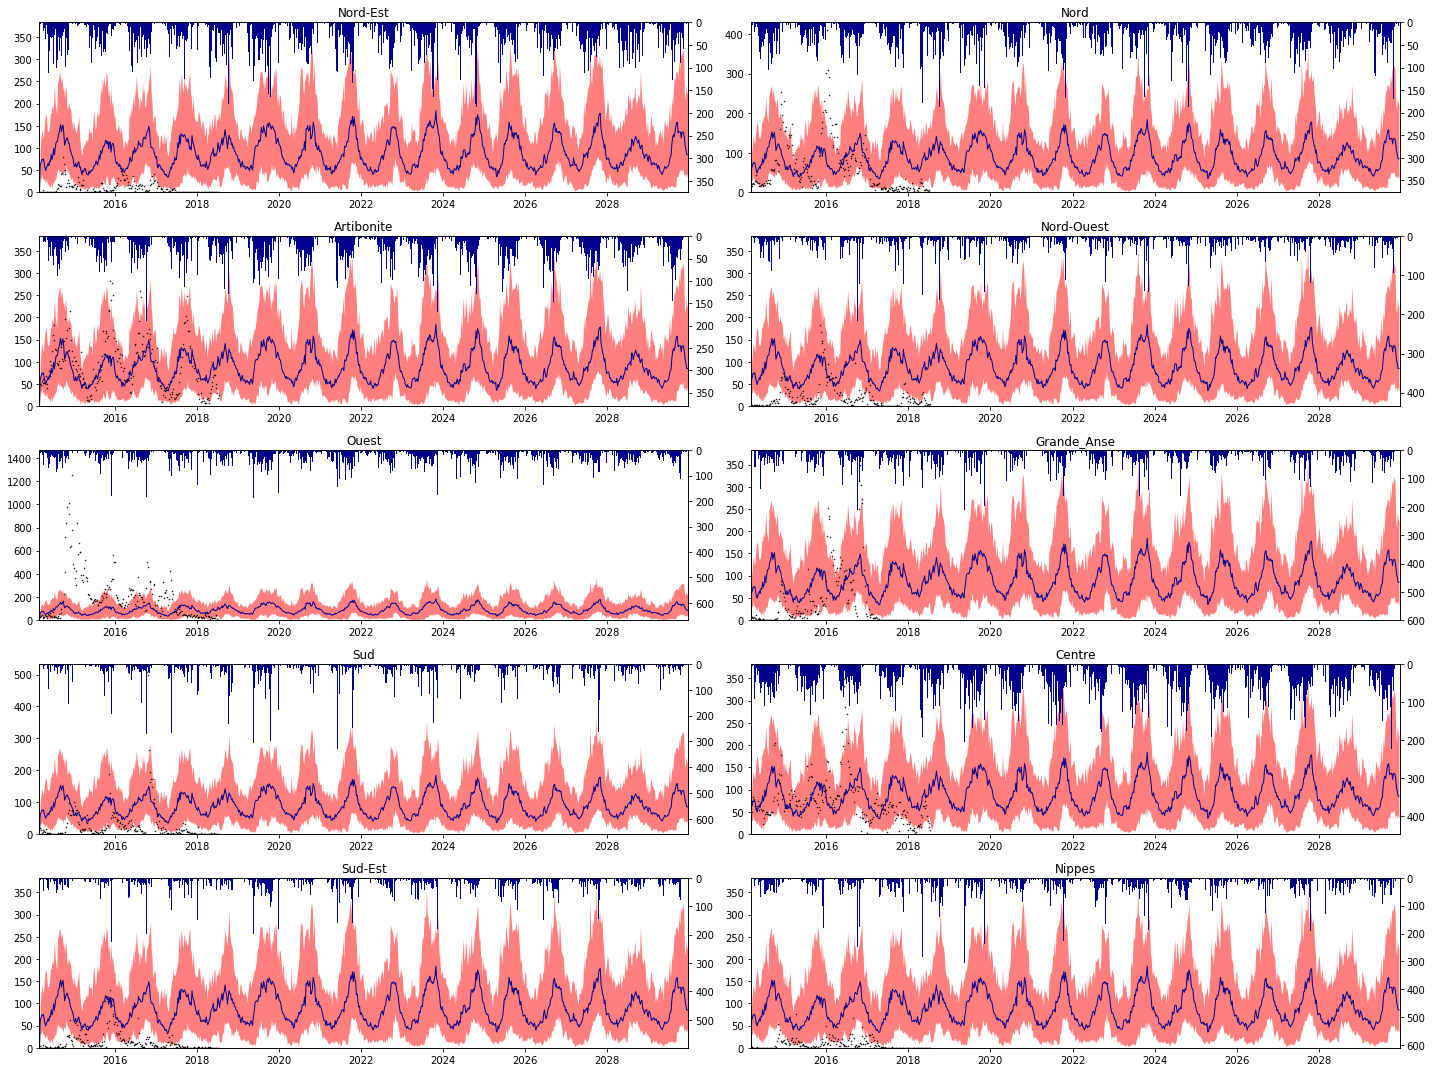

In [22]:
fig, axes = plt.subplots((len(all_data))//2, 2, figsize=(20,15), squeeze = True);
axes = axes.flatten();
for i, dp in enumerate(dept_avail):
    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][t_start:], marker='.', linestyle='-',color='k', linewidth=0, markersize=1 ) 
    axes[i].fill_between(all_data[dp]['cases']['q05'].index, all_data[dp]['cases']['q05'], all_data[dp]['cases']['q95'], alpha = .5, color = 'red', linewidth = 0)
    #axes[i].plot(all_data[dp]['cases']['mean'], linewidth=1, alpha = 1,linestyle='-.', color = 'black')
    axes[i].plot(all_data[dp]['cases']['q50'], alpha = 1,linestyle='-', linewidth = 1, color = 'darkblue')
    axt.bar(pd.date_range(t_start,t_for, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[t_start:t_for], 
                label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0)
    axt.set_ylim(2*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(t_start, t_for)
    #axes[i].legend()
    
fig.tight_layout()

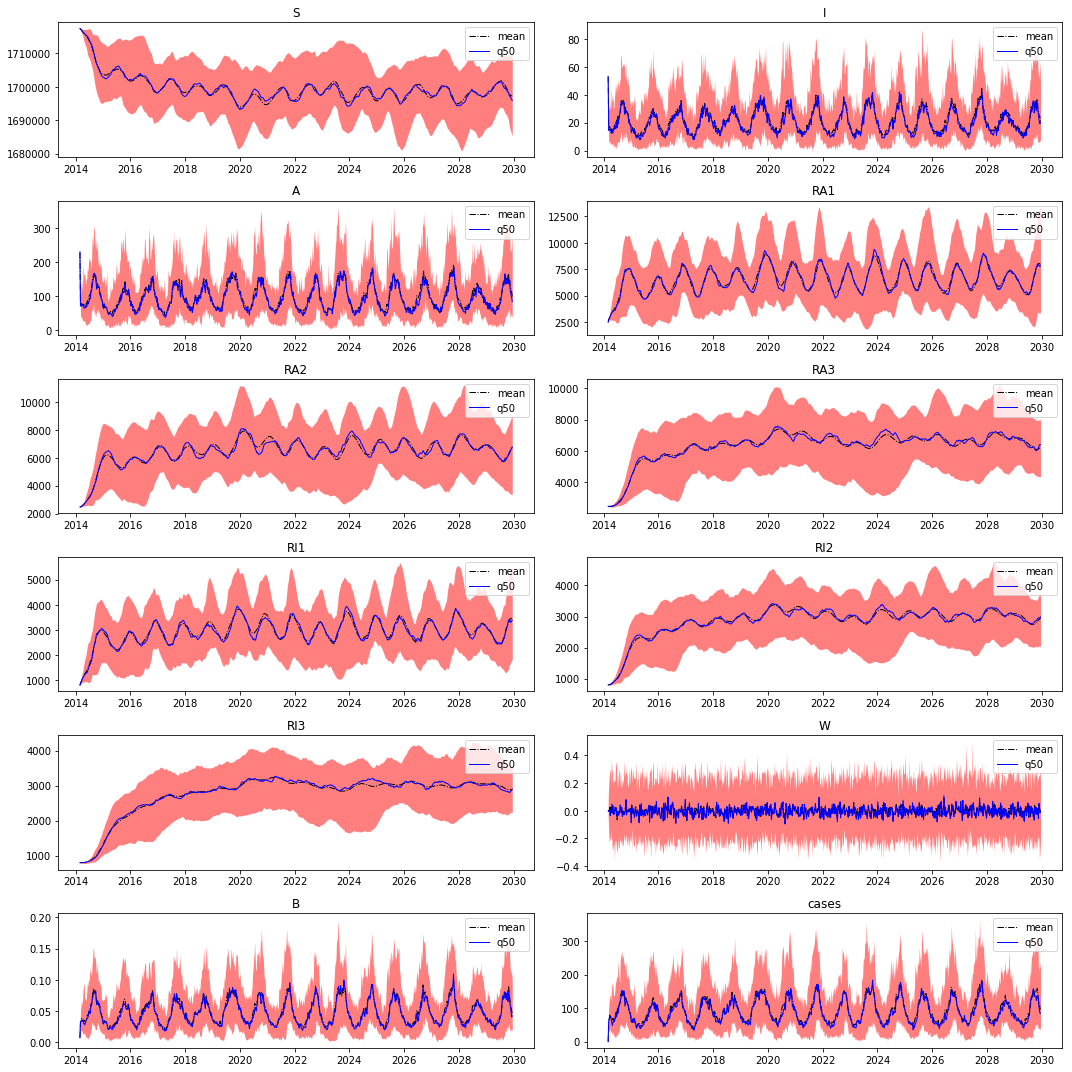

In [23]:
dp = 'Sud-Est'
fig, axes = plt.subplots((len(compartments))//2, 2, figsize=(15,15), squeeze = True);
axes = axes.flatten();
for i, comp in enumerate(compartments):
    axes[i].fill_between(all_data[dp][comp]['q05'].index, all_data[dp][comp]['q05'], all_data[dp][comp]['q95'], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data[dp][comp]['mean'], linewidth=1, alpha = 1,linestyle='-.', color = 'black')
    axes[i].plot(all_data[dp][comp]['q50'], alpha = 1,linestyle='-', linewidth = 1, color = 'blue') 
    axes[i].set_title(comp)
    axes[i].legend()
    
fig.tight_layout()

In [16]:
robjects.r['params'].shape

(31,)

In [14]:
dp

'Nord-Ouest'

In [15]:
all_params.loc[dp]

sigma      0.0
betaB      0.0
mu_B       0.0
XthetaA    0.0
thetaI     0.0
gammaI     0.0
lambda     0.0
lambdaR    0.0
r          0.0
rhoA       0.0
XrhoI      0.0
std_W      0.0
epsilon    0.0
k          0.0
foi_add    0.0
Rtot_0     0.0
gammaA     0.0
H          0.0
D          0.0
mu         0.0
alpha      0.0
I_0        0.0
A_0        0.0
B_0        0.0
RI1_0      0.0
RI2_0      0.0
RI3_0      0.0
RA1_0      0.0
RA2_0      0.0
RA3_0      0.0
Name: Nord-Ouest, dtype: float64

In [3]:
params_disp.loc[:,'gammaA']

Nord-Ouest       1553.164948
Grande_Anse     94771.239030
Nippes          14345.663114
Sud-Est        206851.460168
Centre         711836.252062
Artibonite       7909.085900
Nord-Est       360636.089059
Ouest            4237.427318
Nord             7788.963029
Sud              1628.412113
Name: gammaA, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b49f18cf8>,
      dtype=object)

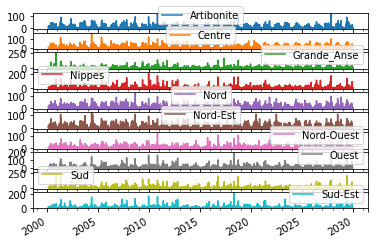

In [6]:
rain.plot(subplots=True)